## I310D: Telco Customer Churn

### ChatCCP - Elizabeth Luu, Jamie Lee, Jihan Song, Yvonne Chen

Identify users at risk of churn (act of customer no longer paying for services) and proposing a solution to limit churn for Telco (fictional company, data provided by IBM)

### 1. Data Inspection

In [4]:
import pandas as pd
import xlrd

In [5]:
telco_df = pd.read_excel('Telco_customer_churn.xlsx')
telco_df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


There are unnecessary (redundant) columns that could be erased. For example, Country, State, City, Lat Long, Latitude, and Longtitude can be replaced by Zip code. Column Count can also be removed since it only has 1 value as 1 for every column. After running the model, we can inspect more in-depth by comparing accuracy drop. Also, it looks like "Churn Reason" could be effectively used for qualitative research later. So, we are going to have two separate datasets for (1) training model (2) qualitative research.

In [6]:
# create dataframe for model 
model_df = telco_df[['Zip Code', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Value', 'CLTV','Churn Score']].copy() 
# create dataframe for qualitative research
churn_reason_df = telco_df[['CustomerID','Churn Reason']].copy()

### 2. Training the model

(a) drop the possible duplicates and rows with NA value and store features and label in two different dataframe

In [4]:
model_df = model_df.drop_duplicates()
model_df = model_df.dropna()

# create separate df for categorical for OHE
model_feature_categorical = model_df[['Zip Code','Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method']].copy()
model_feature_continuous = model_df[['Tenure Months', 'Monthly Charges',
       'Total Charges', 'CLTV','Churn Score']].copy()

model_label = model_df[['Churn Value']].copy()

(b) transform categorical vectors using one-hot-encoder and scale features

In [5]:
model_feature_categorical = pd.get_dummies(data = model_feature_categorical)

In [6]:
# zip code OHE - did not work with dummies 
from sklearn.preprocessing import OneHotEncoder

zip_to_list = model_feature_categorical["Zip Code"].to_list()
zip_to_list_of_lists = []

for zc in zip_to_list:
    zip_to_list_of_lists.append([zc])

zip_ohe = OneHotEncoder()
zip_ohe.fit(zip_to_list_of_lists)

zip_transformed = zip_ohe.transform(zip_to_list_of_lists)
zip_transformed = zip_transformed.toarray()
zip_transformed_df = pd.DataFrame(zip_transformed)

model_feature_categorical.reset_index(drop = True, inplace = True)
zip_transformed_df.reset_index(drop = True, inplace = True)

model_feature_categorical = pd.concat([model_feature_categorical, zip_transformed_df], axis = 1)
model_feature_categorical = model_feature_categorical.drop(columns=["Zip Code"], axis = 1)

In [7]:
from sklearn.preprocessing import StandardScaler

# need to clean the data first
def clean(s):
    if isinstance(s, str):
        s = s.replace(" ","")
        try:
            s = float(s)
        except:
            s = False
    
    return s

model_feature_continuous["Tenure Months"] = model_feature_continuous["Tenure Months"].apply(clean)
model_feature_continuous["Monthly Charges"] = model_feature_continuous["Monthly Charges"].apply(clean)
model_feature_continuous["Total Charges"] = model_feature_continuous["Total Charges"].apply(clean)
model_feature_continuous["CLTV"] = model_feature_continuous["CLTV"].apply(clean)
model_feature_continuous["Churn Score"] = model_feature_continuous["Churn Score"].apply(clean)


# then scale
scaler = StandardScaler()
all_columns = model_feature_continuous.columns

model_feature_continuous[all_columns] = scaler.fit_transform(model_feature_continuous[all_columns])
model_feature_continuous.head()

,Tenure Months,Monthly Charges,Total Charges,CLTV,Churn Score
0,-1.236724,-0.362660,-0.958066,-0.981675,1.268402
1,-1.236724,0.197365,-0.938874,-1.436462,0.385650
2,-0.992402,1.159546,-0.643789,0.821409,1.268402
3,-0.177995,1.330711,0.338085,0.509483,1.175481
4,0.677133,1.294151,1.216150,0.794358,1.407784


In [8]:
model_feature = pd.concat([model_feature_continuous.reset_index(drop=True),
                           model_feature_categorical.reset_index(drop=True)], axis=1)

In [9]:
model_feature.head()

,Tenure Months,Monthly Charges,Total Charges,CLTV,Churn Score,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,Partner_No,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651
0,-1.236724,-0.362660,-0.958066,-0.981675,1.268402,0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.236724,0.197365,-0.938874,-1.436462,0.385650,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.992402,1.159546,-0.643789,0.821409,1.268402,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.177995,1.330711,0.338085,0.509483,1.175481,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.677133,1.294151,1.216150,0.794358,1.407784,0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(c) divide the dataset (using k-fold, k=5)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# extract test data and store it in x_test, y_test
features = model_feature.to_numpy()
labels = model_label.to_numpy()
_x, x_test, _y, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

# set k = 5
k = 5

kfold_spliiter = KFold(n_splits=k)

folds_data = []

fold = 1
for train_index, validation_index in kfold_spliiter.split(_x):
    x_train , x_valid = _x[train_index,:],_x[validation_index,:]
    y_train , y_valid = _y[train_index,:] , _y[validation_index,:]
    print (f"Fold {fold} training data shape = {(x_train.shape,y_train.shape)}")
    print (f"Fold {fold} validation data shape = {(x_valid.shape,y_valid.shape)}")
    fold+=1
    folds_data.append((x_train,y_train,x_valid,y_valid))

Fold 1 training data shape = ((5070, 1700), (5070, 1))
Fold 1 validation data shape = ((1268, 1700), (1268, 1))
Fold 2 training data shape = ((5070, 1700), (5070, 1))
Fold 2 validation data shape = ((1268, 1700), (1268, 1))
Fold 3 training data shape = ((5070, 1700), (5070, 1))
Fold 3 validation data shape = ((1268, 1700), (1268, 1))
Fold 4 training data shape = ((5071, 1700), (5071, 1))
Fold 4 validation data shape = ((1267, 1700), (1267, 1))
Fold 5 training data shape = ((5071, 1700), (5071, 1))
Fold 5 validation data shape = ((1267, 1700), (1267, 1))


(d) train and run the model

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Keep all the models in a dictionary

svm_linear = SVC(kernel="linear")
svm_poly2 = SVC(kernel="poly",degree=2)
svm_poly3 = SVC(kernel="poly",degree=3)
svm_poly4 = SVC(kernel="poly",degree=4)

all_models = {"svm_linear":svm_linear,
              "svm_poly2":svm_poly2, 
              "svm_poly3":svm_poly3,
              "svm_poly4":svm_poly4}

best_validation_accuracy = 0
best_model_name = ""
best_model = None

# Iterate over all models
for model_name in all_models.keys():
    
    print (f"Evaluating {model_name} ...")
    model = all_models[model_name]
    
    # Let's store training and validation accuracies for all folds
    train_acc_for_all_folds = []
    valid_acc_for_all_folds = []
    
    #Iterate over all folds
    for i, fold in enumerate(folds_data):
        x_train, y_train, x_valid, y_valid = fold

        # Train the model
        _ = model.fit(x_train,y_train.flatten())

        # Evluate model on training data
        y_pred_train = model.predict(x_train)
        
        # Evaluate the model on validation data
        y_pred_valid = model.predict(x_valid)
        
        # Compute training accuracy
        train_acc = accuracy_score(y_pred_train , y_train.flatten())
        
        # Store training accuracy for each folds
        train_acc_for_all_folds.append(train_acc)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_pred_valid , y_valid.flatten())

        # Store validation accuracy for each folds
        valid_acc_for_all_folds.append(valid_acc)
    
    #average training accuracy across k folds
    avg_training_acc = sum(train_acc_for_all_folds)/k
    
    print (f"Average training accuracy for model {model_name} = {avg_training_acc}")
    
    #average validation accuracy across k folds
    avg_validation_acc = sum(valid_acc_for_all_folds)/k
    
    print (f"Average validation accuracy for model {model_name} = {avg_validation_acc}")
    
    # Select best model based on average validation accuracy
    if avg_validation_acc > best_validation_accuracy:
        best_validation_accuracy = avg_validation_acc
        best_model_name = model_name
        best_model = model
    print (f"-----------------------------------")

print (f"Best model for the task is {best_model_name} which offers the validation accuracy of {best_validation_accuracy}")

In [ ]:
# the number of unique vlaue == number of features after OHE in that col

mfc = model_df[['Zip Code','Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method']].copy()

for col in mfc.columns:
    print(col,':',len(mfc[col].unique()),'labels')

### 3. Feature Re-Selection by Ablation Test

In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Let's run ablation tests on our best model - svm_poly, degree = 2
best_model = SVC(kernel="poly",degree=2)

# feature and its no. of columns dictionary
dic = {"NO ABLATION":0, "Tenure Months": 1, "Monthly Charges": 1, 
       "Total Charges":1,"CLTV":1, "Churn Score":1,'Gender':2, 'Senior Citizen':2, 'Partner':2,
       'Dependents':2, 'Phone Service':2, 'Multiple Lines':3,
       'Internet Service':3, 'Online Security':3, 'Online Backup':3,
       'Device Protection':3, 'Tech Support':3, 'Streaming TV':3, 'Streaming Movies':3,
       'Contract':3, 'Paperless Billing':2, 'Payment Method':4,'Zip Code':1652}

keysList = list(dic.keys())

# Let's maintain an accuracy dictionary
accuracy_log = {}

ind = 0

for feature_name in keysList:
    print (f"Removing feature \"{feature_name}\"")
    step = dic[feature_name]
    x_ablated = np.delete(_x,np.s_[ind:ind+step],axis=1)
    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Average_cv_score: \"{average_cv_score}\"")
    accuracy_log[feature_name] = average_cv_score
    ind += step

Removing feature "NO ABLATION"
Average_cv_score: "0.919849417013786"
Removing feature "Tenure Months"
Average_cv_score: "0.919691812797064"
Removing feature "Monthly Charges"
Average_cv_score: "0.9201651234068404"
Removing feature "Total Charges"
Average_cv_score: "0.9211116201364907"
Removing feature "CLTV"
Average_cv_score: "0.9222155965929604"
Removing feature "Churn Score"
Average_cv_score: "0.8079832884754717"
Removing feature "Gender"
Average_cv_score: "0.9215845572765593"
Removing feature "Senior Citizen"
Average_cv_score: "0.9198492925238835"
Removing feature "Partner"
Average_cv_score: "0.9201649989169379"
Removing feature "Dependents"
Average_cv_score: "0.9168515756686976"
Removing feature "Phone Service"
Average_cv_score: "0.919375981914107"
Removing feature "Multiple Lines"
Average_cv_score: "0.9207954157838257"
Removing feature "Internet Service"
Average_cv_score: "0.9204800828604792"
Removing feature "Online Security"
Average_cv_score: "0.919533586130829"
Removing feature

In [14]:
# this is to acquire accuracy drop log
acc_drop_log = {}
no_ab_score = accuracy_log["NO ABLATION"]
keys_list = list(accuracy_log.keys())

for x in keys_list:
    value = accuracy_log[x]
    acc_drop_log[x] = no_ab_score - value

acc_drop_log = dict(sorted(acc_drop_log.items(), key=lambda x:x[1],reverse = True))
keys_listt = list(acc_drop_log.keys())

print("FEATURE RANKED BY IMPORTANCE")
for i in range(len(keys_listt)):
    feature_name = keys_listt[i]
    value = acc_drop_log[feature_name]
    
    print(f"{i+1}. {feature_name}, drop: {value}")

FEATURE RANKED BY IMPORTANCE
1. Churn Score, drop: 0.11186612853831424
2. Dependents, drop: 0.0029978413450884034
3. Streaming TV, drop: 0.0006309148264984632
4. Phone Service, drop: 0.0004734350996790093
5. Online Security, drop: 0.0003158308829569467
6. Tenure Months, drop: 0.00015760421672195157
7. Senior Citizen, drop: 1.244899024976931e-07
8. Streaming Movies, drop: 1.244899024976931e-07
9. NO ABLATION, drop: 0.0
10. Zip Code, drop: -0.0003150839435415165
11. Partner, drop: -0.00031558190315195134
12. Monthly Charges, drop: -0.00031570639305444903
13. Contract, drop: -0.000472688160263357
14. Device Protection, drop: -0.00047293714006857446
15. Online Backup, drop: -0.0006304168668879173
16. Internet Service, drop: -0.0006306658466932458
17. Multiple Lines, drop: -0.0009459987700397576
18. Tech Support, drop: -0.0011042254362748638
19. Total Charges, drop: -0.0012622031227047525
20. Gender, drop: -0.001735140262773327
21. Payment Method, drop: -0.0018926199895927809
22. Paperless 

The result gives us that most of the categorical values were not actually helpful, except Dependents, Streaming TV, Phone Service, Online Security, Senior Citizen,and Streaming Movies. Another problem (which we expected) was that the model learned a lot from the Churn Score, which is already a value with calculation. So, we decided to remove this feature and others to see how things look like.

## Best model

In [44]:
"""
get the refined dataset
"""
from sklearn.preprocessing import OneHotEncoder

refined_dataset = model_df[["Dependents", "Streaming TV", "Phone Service",
                            "Online Security", "Senior Citizen", "Streaming Movies"]]
onehot = OneHotEncoder()
refined_dataset_one_hot = onehot.fit_transform(refined_dataset).toarray()

In [45]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# The group that performs best in the above model
X_train, X_test, y_train, y_test = train_test_split(
    refined_dataset_one_hot, model_label.values.reshape(-1), test_size=0.3, random_state=42)

svm_poly2 = SVC(kernel="poly", degree=2)
svm_poly2.fit(X_train,y_train)
print("Accuracy: ",accuracy_score(svm_poly2.predict(X_test),y_test))

Accuracy:  0.7335541883577852


## Test bias

### Gender

In [80]:
# Original gender ratio
model_feature["Gender_Female"].value_counts()

0    3555
1    3488
Name: Gender_Female, dtype: int64

In [82]:
column_name = "Gender_Female"
gender_feature = model_feature.copy()
"""
Generate false gender data
"""
# Randomly select rows to replace
to_replace = gender_feature.loc[gender_feature[column_name].isin(
    [0, 1])].sample(5000, random_state=42).index
# Swap 0 and 1
gender_feature.loc[to_replace, column_name] = gender_feature.loc[to_replace,
                                                                 column_name].apply(lambda x: 1 if x == 0 else 1)
gender_dict = {0: 1, 1: 0}
gender_feature["Gender_Male"] = gender_feature["Gender_Female"].apply(
    lambda x: gender_dict[x])

In [83]:
# Gender ratio after treatment
gender_feature["Gender_Female"].value_counts()

1    5995
0    1048
Name: Gender_Female, dtype: int64

In [84]:
# Merge refined datasets and gender features
extra_feature = (gender_feature[["Gender_Female","Gender_Male"]]).values
gender_feature = np.concatenate([refined_dataset_one_hot,extra_feature],axis=1)

In [85]:
# split the train and test
X_train, X_test, y_train, y_test = train_test_split(
    gender_feature, model_label.values.reshape(-1), test_size=0.3, random_state=42)

svm_poly2 = SVC(kernel="poly", degree=2)
svm_poly2.fit(X_train,y_train)
print("Accuracy: ",accuracy_score(svm_poly2.predict(X_test),y_test))

Accuracy:  0.7335541883577852


### Senior Citizen

In [86]:
model_feature["Senior Citizen_Yes"].value_counts()

0    5901
1    1142
Name: Senior Citizen_Yes, dtype: int64

In [95]:
column_name = "Senior Citizen_Yes"
Seniorr_feature = model_feature.copy()
"""
Generate false Senior Citizen data
"""
# Randomly select rows to replace
to_replace = Seniorr_feature.loc[Seniorr_feature[column_name].isin(
    [0, 1])].sample(6500, random_state=42).index
# Swap 0 and 1
Seniorr_feature.loc[to_replace, column_name] = Seniorr_feature.loc[to_replace,
                                                                 column_name].apply(lambda x: 1 if x == 0 else 1)
Seniorr_dict = {0: 1, 1: 0}
Seniorr_feature["Senior Citizen_No"] = Seniorr_feature["Senior Citizen_Yes"].apply(
    lambda x: Seniorr_dict[x])

In [96]:
Seniorr_feature["Senior Citizen_Yes"].value_counts()

1    6600
0     443
Name: Senior Citizen_Yes, dtype: int64

In [97]:
# Merge refined datasets and Senior Citizen features
extra_feature = (Seniorr_feature[["Senior Citizen_Yes","Senior Citizen_No"]]).values
Seniorr_feature = np.concatenate([refined_dataset_one_hot,extra_feature],axis=1)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    Seniorr_feature, model_label.values.reshape(-1), test_size=0.3, random_state=42)

svm_poly2 = SVC(kernel="poly", degree=2)
svm_poly2.fit(X_train,y_train)
print("Accuracy: ",accuracy_score(svm_poly2.predict(X_test),y_test))

Accuracy:  0.7335541883577852


### Partner

In [100]:
model_feature["Partner_Yes"].value_counts()

0    3641
1    3402
Name: Partner_Yes, dtype: int64

In [109]:
column_name = "Partner_Yes"
partner_feature = model_feature.copy()
"""
Generate false Partner data
"""
# Randomly select rows to replace
to_replace = partner_feature.loc[partner_feature[column_name].isin(
    [0, 1])].sample(5000, random_state=42).index
# Swap 0 and 1
partner_feature.loc[to_replace, column_name] = partner_feature.loc[to_replace,
                                                                 column_name].apply(lambda x: 1 if x == 0 else 1)
partner_dict = {0: 1, 1: 0}
partner_feature["Partner_No"] = partner_feature["Partner_Yes"].apply(
    lambda x: partner_dict[x])

In [110]:
partner_feature["Partner_Yes"].value_counts()

1    5997
0    1046
Name: Partner_Yes, dtype: int64

In [111]:
# Merge refined datasets and Partner features
extra_feature = (partner_feature[["Partner_Yes","Partner_No"]]).values
partner_feature = np.concatenate([refined_dataset_one_hot,extra_feature],axis=1)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    partner_feature, model_label.values.reshape(-1), test_size=0.3, random_state=42)

svm_poly2 = SVC(kernel="poly", degree=2)
svm_poly2.fit(X_train,y_train)
print("Accuracy: ",accuracy_score(svm_poly2.predict(X_test),y_test))

Accuracy:  0.7335541883577852


### Churn reason analysis

In [7]:
reason_counts = churn_reason_df["Churn Reason"].value_counts()
print(reason_counts)

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

Shows the list of unique reasons and their respective counts.

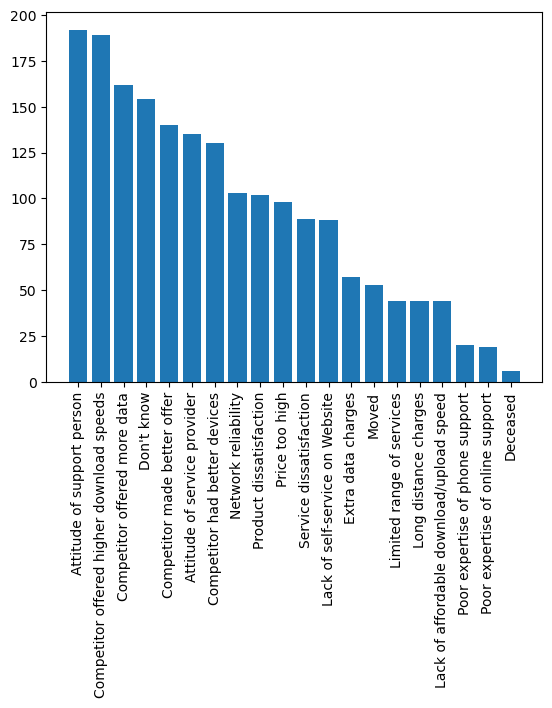

In [9]:
import matplotlib.pyplot as plt

plt.bar(reason_counts.index, reason_counts.values)
plt.xticks(rotation=90)
plt.show()

*** Solutions ***

Here are some possible solutions that we can take to help mitigate the churn rate. 
1. Improve attitude and behavior of service providers and support persons since the are the top reasons for customer churn rates
2. Improve the quality of of devices and offers to help compete the competition
3. Provide faster download times, more data, and reasonable prices
4. Improve the user experience for customers by offering self-service alternatives on the website
5. Broaden the scope of offerings to better serve clients' various demands
6. Lower long-distance and additional data costs to retain customers
7. Enhance network dependability
8. Improve the knowledge of the phone and online support personnel to swiftly handle client difficulties
9. Address complaints about your products and services

It is crucial to remember that while these solutions can dramatically reduce customer turnover and raise overall customer satisfaction, they may not totally eliminate it.

## Conclusion

In this scenario, we used a model to predict customer churn which had an accuracy of 0.73355. We then sequentially changed gender, age, and partner variables to test the model's bias towards certain social factors.

First, we changed gender by labeling all male customers as 1 and all female customers as 0. This resulted in a slight increase in the model's accuracy, from 0.7335541883577852 to 0.7345007098911502, which is a change of only 0.000946521533365. This suggests that gender has a minimal effect on the model's predictions and that there is no bias towards gender.

Next, we changed age by labeling all customers under 65 as 0 and all customers 65 and above as 1. In this case, the model's predicted accuracy remained the same at 0.7335541883577852. We can conclude that the model has no bias towards the age variable.

Finally, we changed the partner variable by labeling all customers without a partner (Partner=0) as 1 and all customers with a partner (Partner=1) as 0. This resulted in an increase in the model's predicted accuracy from 0.7335541883577852 to 0.73739375295788, which is a relative increase of 0.0038395646000948. This suggests that there is a correlation between the partner variable and customer churn, and that the model may have bias towards retaining customers with a partner.

In conclusion, through our experiments with these three variables, we can see that the model has differing biases towards different social factors. For gender and age variables, the model is objective and has no bias, while for the partner variable, the model may have a bias towards retaining customers with a partner. We should be mindful of and avoid any biases in our models and ensure diversity and objectivity in our data when building machine learning models.